In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import csv
import pandas as pd
import matplotlib
%matplotlib inline
from funcsRV import *

matplotlib.rc('xtick', labelsize=23) 
matplotlib.rc('ytick', labelsize=23)


# RV fitting

## Read in RV data

The offsets to get from the relative RVs I provided to an absolute scale are as follows:

K03835482: -64.075 +/- 0.104 km/s

K06233093: -55.631 +/- 0.054 km/s

K12254688: 19.832 +/- 0.053 km/s

K08145411: -27.585 +/- 0.069 km/s


You need to add these values to the derived center of mass velocities to get absolute center of mass velocities. This won't affect your fitting, of course -- just use the RVs provided. If you write this up, though, you'll want to report the actual RV of each system, and not just the relative RVs.

In [2]:
# input the folder name
RVfolder = 'RVdata/'

# input the file names
RVfiles = ['K03835482.vzero.txt', 'K06233093.vzero.txt', 'K08145411.vzero.txt', 'K12254688.vzero.txt']

# make a list of the RV offset to the absolute center of mass velocities
RVoffset = np.array([-64.075, -55.631, 19.832, -27.585])

# make an empty list called data_all where we will save the data...
data_all = []

# start a for loop, looping through our 4 data files
for file in RVfiles:
    # pulls in RV file, set it equal to variable called “data”
    data = pd.read_csv(RVfolder+file, header=None, delim_whitespace=True)
    # add header to each column with information on the data in that column
    data.columns = ('time [days]', 'radial velocities [m/s]', 'radial velocity errors [m/s]')
    # convert RVs and RV errors from m/s to km/s
    data['radial velocities [m/s]'] = data['radial velocities [m/s]']/1000.
    data['radial velocity errors [m/s]'] = data['radial velocity errors [m/s]']/1000.
    
    # change RV and RV errors header to list units in km/s
    data.rename(columns={'radial velocities [m/s]': 'radial velocities [km/s]'}, inplace=True)
    data.rename(columns={'radial velocity errors [m/s]': 'radial velocity errors [km/s]'}, inplace=True)
    
    # convert times to BJD - 2,454,833 BJD and change units in header
    data['time [days]'] = data['time [days]'] - 2454833
    data.rename(columns={'time [days]': 'time [BJD - 2454833]'}, inplace=True)
    
    # append data for one star onto data_all
    data_all.append(data)

# Now let's plot up the data:

In [3]:
for data in data_all:
    print(data)

    time [BJD - 2454833]  radial velocities [km/s]  \
0            2840.681063                   -1.0356   
1            3004.003694                    7.4963   
2            3019.955196                    8.8375   
3            3054.910814                   11.7285   
4            3067.950751                   12.6989   
5            3100.852629                   15.0426   
6            3160.757563                   16.9943   
7            3170.685366                   16.9936   
8            3186.721619                   16.8829   
9            3208.635833                   16.2637   
10           3220.657206                   15.8010   
11           3236.605155                   14.8548   
12           3250.611822                   13.9682   
13           3343.024148                    6.5759   
14           3380.987350                    3.5873   
15           3393.954024                    2.7280   
16           3427.922768                    0.8324   
17           3447.758173    

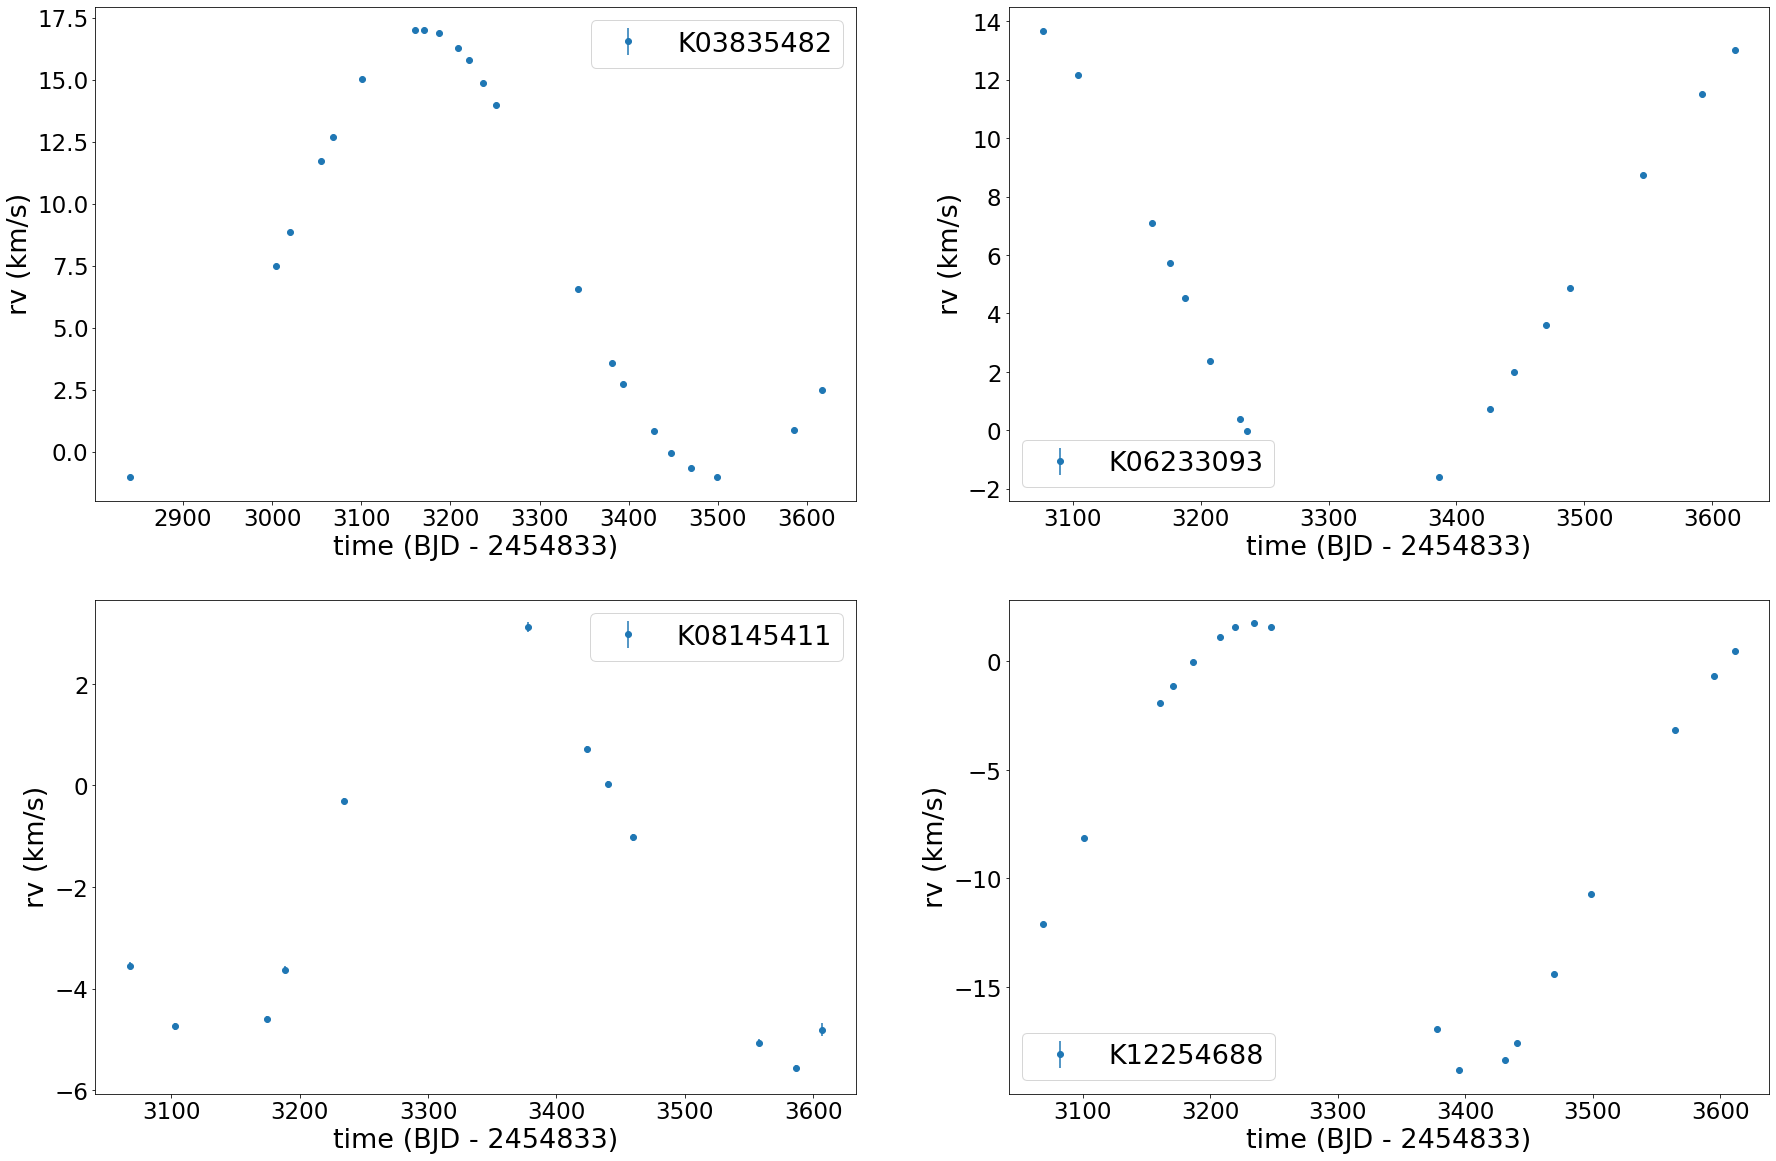

In [4]:
# write the code to plot the time (days) vs. radial velocty (km/s) here:

# allows you to plot multiple plots (rows, columns), figsize = shape
fig, ax = plt.subplots(2, 2, figsize=(30, 20))

index = 0
rows = [0,0,1,1]
columns = [0,1,0,1]

for dataset in data_all:
    time = dataset["time [BJD - 2454833]"]
    rv = dataset["radial velocities [km/s]"]
    rve = dataset["radial velocity errors [km/s]"]
    
    jj = columns[index]
    ii = rows[index]

    axs = ax[ii][jj]
    axs.errorbar(time, rv, yerr = rve, fmt = 'o', label = RVfiles[index][:-10])
    axs.set_ylabel('rv (km/s)', fontsize = 27);
    axs.set_xlabel('time (BJD - 2454833)', fontsize = 27);
    axs.legend(fontsize = 27)
    
    index += 1



## RV results from Masuda et al. 2019 IAU Symposium: https://arxiv.org/pdf/2001.04448.pdf

In [5]:
#RV params = period, ttran, sqrte_cosomega, sqrte_sinomega, K, gamma, jitter

#KIC params = period, ttran (BJD=2454833), e, omega (deg), K (km/s), gamma (km/s), jitter (m/s)

#-------------

KIC3835482   =  [683.266, 591.628, 0.062, 4, 9.07, 7.45, 13]

KIC6233093   =  [727.979, 260.678, 0.123, 112, 9.5, 6.61, 17]

KIC12254688  =  [418.718, 404.583, 0.180, 128, 10.44, -7.49, 17]

KIC8145411   =  [455.83, 267.97, 0.13, -93, 4.59, -0.78, 150]



In [6]:
#pull in original parameters from Masuda IAU values
#pmod = period, ttran (BJD=2454833), e, omega (deg), K (km/s), gamma (km/s), jitter (m/s)
pmod_03835482 = ["K03835482", 683.266, 591.628, 0.062, 4, 9.07, 7.45, 13]
pmod_06233093 = ["K06233093", 727.979, 260.678, 0.123, 112, 9.5, 6.61, 17]
pmod_08145411 = ["K08145411", 455.83, 267.97, 0.13, -93, 4.59, -0.78, 150]
pmod_12254688 = ["K12254688", 418.718, 404.583, 0.180, 128, 10.44, -7.49, 17]

#turn e and omega into sqrte*cos(omega) and sqrte*sin(omega)
#turn jitter into km/s
p_03835482 = pmod_03835482[0:3]+ [np.sqrt(pmod_03835482[3])*np.cos(np.radians(pmod_03835482[4]))] + [np.sqrt(pmod_03835482[3])*np.sin(np.radians(pmod_03835482[4]))] + pmod_03835482[5:7] + [pmod_03835482[7]/1000.]
p_06233093 = pmod_06233093[0:3]+ [np.sqrt(pmod_06233093[3])*np.cos(np.radians(pmod_06233093[4]))] + [np.sqrt(pmod_06233093[3])*np.sin(np.radians(pmod_06233093[4]))] + pmod_06233093[5:7] + [pmod_06233093[7]/1000.]
p_08145411 = pmod_08145411[0:3]+ [np.sqrt(pmod_08145411[3])*np.cos(np.radians(pmod_08145411[4]))] + [np.sqrt(pmod_08145411[3])*np.sin(np.radians(pmod_08145411[4]))] + pmod_08145411[5:7] + [pmod_08145411[7]/1000.]
p_12254688 = pmod_12254688[0:3]+ [np.sqrt(pmod_12254688[3])*np.cos(np.radians(pmod_12254688[4]))] + [np.sqrt(pmod_12254688[3])*np.sin(np.radians(pmod_12254688[4]))] + pmod_12254688[5:7] + [pmod_12254688[7]/1000.]
p_all = [p_03835482, p_06233093, p_08145411, p_12254688]

for p in p_all: print(p)

#change t_tran to be in the middle of the RV observations
for ii in range(0, len(p_all)):
    data = data_all[ii]
    time = data['time [BJD - 2454833]']
    min_time = np.min(time)
    t_tran = p_all[ii][2]
    period = p_all[ii][1]
    while t_tran < min_time:
        t_tran += period
    p_all[ii][2] = t_tran
    print(p_all[ii])
    


['K03835482', 683.266, 591.628, 0.24839144536595595, 0.017369221888481945, 9.07, 7.45, 0.013]
['K06233093', 727.979, 260.678, -0.13137961135264847, 0.3251759488658825, 9.5, 6.61, 0.017]
['K08145411', 455.83, 267.97, -0.01886999737843737, -0.36006099927503643, 4.59, -0.78, 0.15]
['K12254688', 418.718, 404.583, -0.2612030424708523, 0.3343246485139409, 10.44, -7.49, 0.017]
['K03835482', 683.266, 3324.692, 0.24839144536595595, 0.017369221888481945, 9.07, 7.45, 0.013]
['K06233093', 727.979, 3172.594, -0.13137961135264847, 0.3251759488658825, 9.5, 6.61, 0.017]
['K08145411', 455.83, 3458.7799999999997, -0.01886999737843737, -0.36006099927503643, 4.59, -0.78, 0.15]
['K12254688', 418.718, 3335.6089999999995, -0.2612030424708523, 0.3343246485139409, 10.44, -7.49, 0.017]


In [7]:
RVmodels = []
for p in p_all:
    period, ttran, sqrte_cosomega, sqrte_sinomega, K, gamma = p[1:-1]
    RVmodels.append(RV_model(time, period, ttran, sqrte_cosomega, sqrte_sinomega, K, gamma))


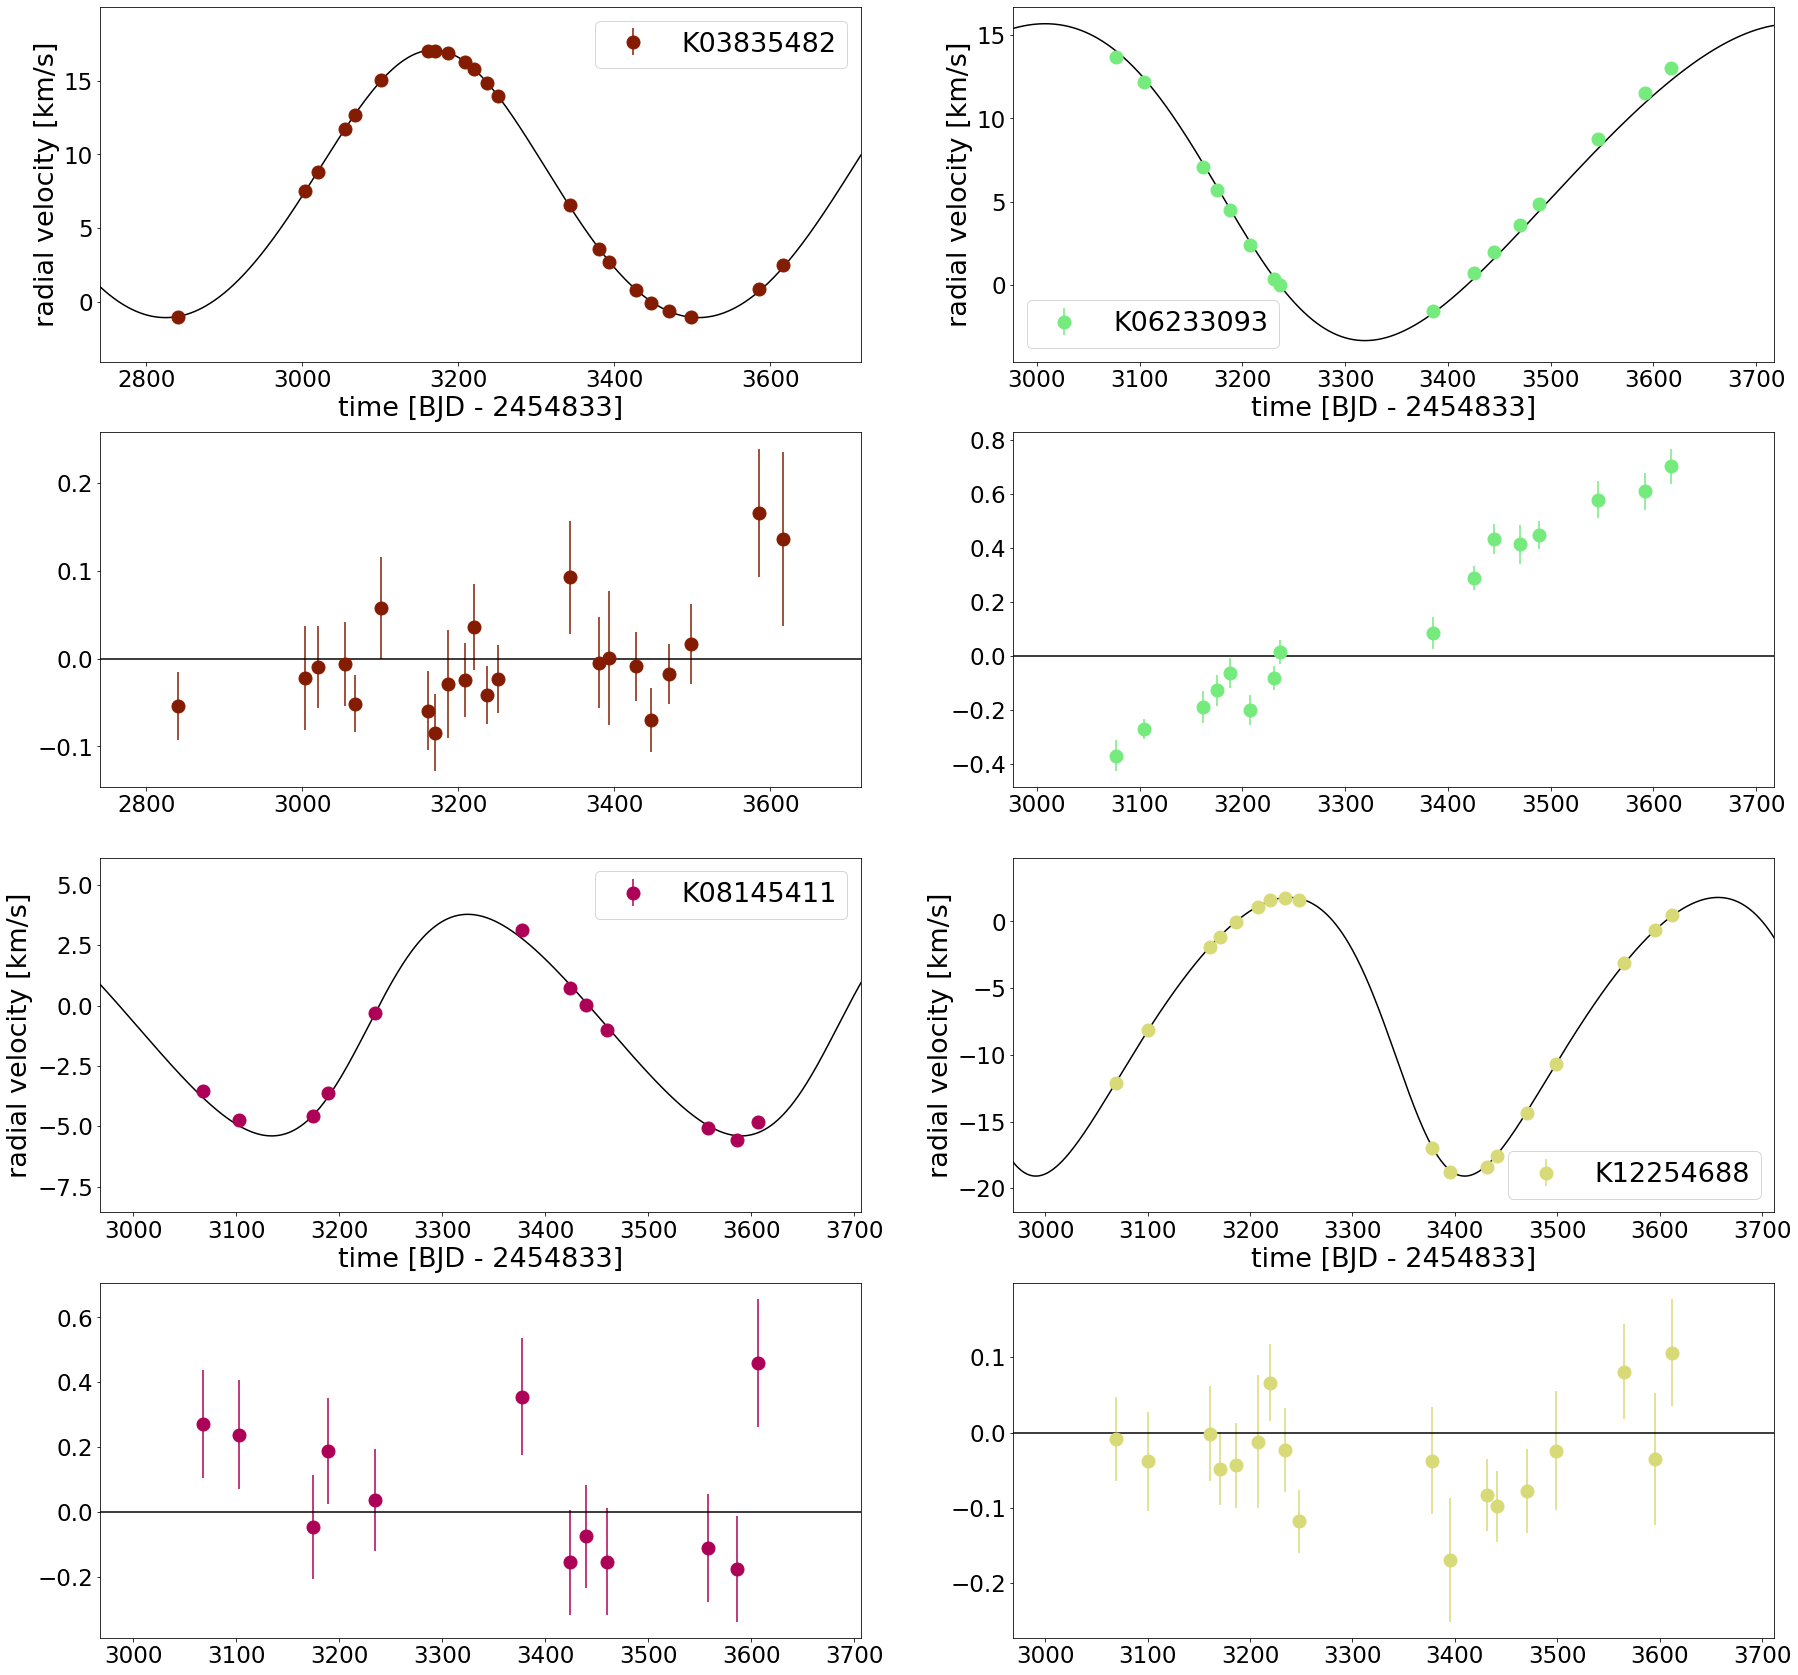

In [8]:
fig, ax = plt.subplots(4,2, figsize = [30,30])
index = 0
columns = [0,0,2,2]
resid_columns = [1,1,3,3]
rows = [0,1,0,1]
colors = ["#831c00", "#75eb7e", "#ad0057", "#d7da77"]

for index in range(0, len(data_all)):
    ii = columns[index]
    jj = rows[index]
    kk = resid_columns[index]
   
    params = p_all[index]
    data = data_all[index]
   
    kic = params[0]    
    period, ttran, sqrte_cosomega, sqrte_sinomega, K, gamma = params[1:-1]
    jitter = params[-1]
   
    time, rv, rv_err = data['time [BJD - 2454833]'], data['radial velocities [km/s]'], data['radial velocity errors [km/s]']
   
    time_model = np.arange(np.min(time)*0.95, np.max(time)*1.05)
    RVmodel = RV_model(time_model, period, ttran, sqrte_cosomega, sqrte_sinomega, K, gamma)
   
    ax[ii][jj].plot(time_model, RVmodel, color = 'k')    
   
    ax[ii][jj].errorbar(time, rv, yerr = np.sqrt(rv_err**2. + jitter**2.), marker = 'o', linestyle = '', label = kic, color = colors[index], markersize = 13)
    ax[ii][jj].set_xlabel('time [BJD - 2454833]', fontsize = 27)
    ax[ii][jj].set_ylabel('radial velocity [km/s]', fontsize = 27)
   
    RVresids = RV_model(time, period, ttran, sqrte_cosomega, sqrte_sinomega, K, gamma)
    ax[kk][jj].plot([np.min(time)*0.95, np.max(time)*1.05], [0., 0.], color = 'k')
    ax[kk][jj].errorbar(time, rv - RVresids, yerr = np.sqrt(rv_err**2. + jitter**2.), fmt = 'o', markersize = 13,  color = colors[index])
    ax[kk][jj].get_shared_x_axes().join(ax[kk][jj], ax[ii][jj])
   
    ax[ii][jj].set_xlim([np.min(time)-100, np.max(time)+100])
    ax[ii][jj].set_ylim([np.min(rv)-3, np.max(rv)+3])
    ax[ii][jj].legend(fontsize = 27)

    index += 1

In [12]:
def runMCMC(p, t, rv, rvErr, outfile, niter=10000, nwalkers=50):

    """
    Run the MCMC Orbital fit to Spectroscopic RV Observations

    Input
    -----
    p : ndarray
        Orbital parameters. See RV model in funcs.py for order
    t, rv, rvErr : Ndarray
        times, RV, and RV errors of the data.
    outfile : string
        name of output file where MCMC chain is stored
    niter : int, optional
            number of MCMC iterations to run. Default = 10,000
    nwalkers : int, optional
        number of MCMC walkers in modeling. Default = 50

    Returns
    ------
    String stating "MCMC complete"

    (Outputs MCMC chain into file labeled whatever input into variable: outfile)


    """

    ndim = len(p)



    #start walkers in a ball near the optimal solution
    startlocs = [p + initrange(p) * np.random.randn(ndim) for i in np.arange(nwalkers)]

    #run emcee MCMC code
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, args = [t, rv, rvErr])

    #clear output file
    ofile = open(outfile, 'w')
    ofile.close()

    iternum = 1
    #run the MCMC...record parameters for every walker at every step
    for result in sampler.sample(startlocs, iterations = niter, store = False):
        pos = result.coords
        ofile = open(outfile, 'a')

        #write iteration number, walker number, and log likelihood
        #and value of parameters for the step
        for walker in np.arange(pos.shape[0]):
            ofile.write('{0} {1} {2} {3}\n'.format(iternum, walker, str(result.log_prob[walker]), " ".join([str(x) for x in pos[walker]])))

        ofile.close()


        #keep track of step number
        mod = iternum % 1000
        if mod == 0:
            print(iternum)
            print(pos[0])

        iternum += 1
    return "MCMC complete"

In [13]:
for index in range(0, len(data_all)):
    data = data_all[index]
    time, rv, rv_err = data['time [BJD - 2454833]'], data['radial velocities [km/s]'], data['radial velocity errors [km/s]']
    p = p_all[index][1:]
    kic = p_all[index][0]
    filename = 'chain_test_' + kic + '.csv'
    runMCMC(p, time, rv, rv_err, filename, niter=10000, nwalkers=50)

1000
[6.79162751e+02 3.32425081e+03 2.41613710e-01 2.35020388e-02
 9.01620833e+00 7.48310868e+00 7.63524296e-03]
2000
[6.79395659e+02 3.32560889e+03 2.35861056e-01 8.74332644e-03
 9.04177150e+00 7.45427102e+00 1.66267157e-03]
3000
[6.79089634e+02 3.32585352e+03 2.31221611e-01 2.07147160e-02
 9.05023070e+00 7.49343323e+00 1.59499615e-02]
4000
[6.78422274e+02 3.32547062e+03 2.33398933e-01 1.16540268e-02
 9.03844275e+00 7.48385552e+00 2.58696735e-04]
5000
[ 6.75818933e+02  3.32501575e+03  2.34366540e-01 -9.72796054e-03
  9.07933840e+00  7.48795299e+00  1.35308910e-02]
6000
[6.82588978e+02 3.32588725e+03 2.37312389e-01 2.85352714e-02
 9.04928984e+00 7.45983174e+00 6.13581352e-03]
7000
[ 6.77454459e+02  3.32554761e+03  2.33780563e-01 -3.67564479e-03
  9.06108156e+00  7.50778891e+00  3.70979472e-02]
8000
[6.78551715e+02 3.32511306e+03 2.36059490e-01 1.17592061e-02
 9.06137148e+00 7.46722230e+00 7.09004617e-05]
9000
[6.81066921e+02 3.32529885e+03 2.40103142e-01 2.10906964e-02
 9.04522998e+00 

/Users/Danielyahalomi/Documents/SRMP/Self-Lensing/RV/funcsRV.py:99: RuntimeWarning: invalid value encountered in sqrt
  tau = (ttran + np.sqrt(edif) * period / (2 * np.pi) *
/Users/Danielyahalomi/Documents/SRMP/Self-Lensing/RV/funcsRV.py:100: RuntimeWarning: invalid value encountered in sqrt
  (e * np.sin(fcen) / (1. + e * np.cos(fcen)) - 2. / np.sqrt(edif) *
/Users/Danielyahalomi/Documents/SRMP/Self-Lensing/RV/funcsRV.py:101: RuntimeWarning: invalid value encountered in sqrt
  np.arctan(np.sqrt(edif) * np.tan(fcen / 2.) / (1. + e))))
/Users/Danielyahalomi/Documents/SRMP/Self-Lensing/RV/funcsRV.py:113: RuntimeWarning: invalid value encountered in sqrt
  tanf2 = np.sqrt((1. + e) / (1. - e)) * np.tan(E / 2.)


1000
[ 6.92487403e+02  3.17345366e+03 -1.20493436e-01  3.00485947e-01
  9.28793629e+00  6.29912512e+00  2.65134295e-02]
2000
[ 6.87651438e+02  3.17432951e+03 -1.14975735e-01  2.99229050e-01
  9.14614490e+00  6.20261829e+00  6.19074315e-03]
3000
[ 6.94237537e+02  3.17349645e+03 -1.23302210e-01  2.98320327e-01
  9.23578080e+00  6.30523811e+00  8.54748190e-02]
4000
[ 6.54519081e+02  3.17526339e+03 -1.08608411e-02  3.18260452e-01
  8.83589032e+00  5.76112068e+00  6.74622611e-02]
5000
[ 7.03645884e+02  3.17126633e+03 -1.21216988e-01  2.97628522e-01
  9.27583178e+00  6.46300032e+00  1.56034203e-02]
6000
[ 7.01403520e+02  3.17140137e+03 -1.06280265e-01  3.04829666e-01
  9.24296081e+00  6.43579212e+00  7.28212730e-02]
7000
[ 7.51398214e+02  3.16837187e+03 -2.08053675e-01  2.77370453e-01
  9.68723867e+00  7.07421688e+00  7.40881634e-02]
8000
[ 6.91435235e+02  3.17439324e+03 -1.28075106e-01  2.96739961e-01
  9.18642531e+00  6.25279825e+00  1.31951720e-02]
9000
[ 6.86949180e+02  3.17383076e+03 -1